# Mixed Data Sampling(MIDAS) for predicting quaterly Typical Price 

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from midas.mix import mix_freq, mix_freq2
from midas.adl import estimate, forecast, midas_adl, rmse, estimate2,forecast2, midas_adl2
import datetime
import math

##  Load Amazon data


In [4]:
amzn = pd.read_csv('/Users/haroonperveez/Downloads/AMZN_long2.csv')
amzn.tail()
amzn['Date'] = pd.to_datetime(amzn['Date'])
amzn.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
984,2019-11-29,1817.780029,1824.689941,1800.790039,1800.800049,1800.800049,1923400
985,2019-12-02,1804.400024,1805.550049,1762.680054,1781.599976,1781.599976,3925600
986,2019-12-03,1760.000000,1772.869995,1747.229980,1769.959961,1769.959961,3380900
987,2019-12-04,1774.010010,1789.089966,1760.219971,1760.689941,1760.689941,2670100
988,2019-12-05,1763.500000,1763.500000,1740.000000,1740.479980,1740.479980,2823800


In [5]:
amzn = pd.read_excel("../data/AMZN.xls")
amzn.head()

,Date,Open,Close,High,Low,Volume
0,2016-01-04,656.289978,636.989990,657.719971,627.510010,9314500
1,2016-01-05,646.859985,633.789978,646.909973,627.650024,5822600
2,2016-01-06,622.000000,632.650024,639.789978,620.309998,5329200
3,2016-01-07,621.799988,607.940002,630.000000,605.210022,7074900
4,2016-01-08,619.659973,607.049988,624.140015,606.000000,5512900


In [6]:
amzn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 6 columns):
Date      878 non-null datetime64[ns]
Open      878 non-null float64
Close     878 non-null float64
High      878 non-null float64
Low       878 non-null float64
Volume    878 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 41.2 KB


### Calculating daily typical price of AMZN  that is mean of (High+Low+Close)

In [7]:
amzn['Typical_Price'] = amzn[['High','Low','Close']].mean(axis=1)
amzn.head()


,Date,Open,Close,High,Low,Volume,Typical_Price
0,2016-01-04,656.289978,636.989990,657.719971,627.510010,9314500,640.739990
1,2016-01-05,646.859985,633.789978,646.909973,627.650024,5822600,636.116658
2,2016-01-06,622.000000,632.650024,639.789978,620.309998,5329200,630.916667
3,2016-01-07,621.799988,607.940002,630.000000,605.210022,7074900,614.383341
4,2016-01-08,619.659973,607.049988,624.140015,606.000000,5512900,612.396668


### Fama French Data


In [8]:
fama = pd.read_csv("../data/F-F_Research_Data_Factors_daily.csv")
fama.head()

,Date,Mkt-RF,SMB,HML,RF
0,19260701,0.10,-0.24,-0.28,0.009
1,19260702,0.45,-0.32,-0.08,0.009
2,19260706,0.17,0.27,-0.35,0.009
3,19260707,0.09,-0.59,0.03,0.009
4,19260708,0.21,-0.36,0.15,0.009


In [9]:
fama.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24559 entries, 0 to 24558
Data columns (total 5 columns):
Date      24559 non-null int64
Mkt-RF    24559 non-null float64
SMB       24559 non-null float64
HML       24559 non-null float64
RF        24559 non-null float64
dtypes: float64(4), int64(1)
memory usage: 959.4 KB


### 'Date' is an object. Hence, we need to convert it to Date format.

In [10]:
fama['Date'] = pd.to_datetime(fama['Date'], format='%Y%m%d')

In [11]:
fama['Date'].dtype

dtype('<M8[ns]')

# ADS index data

In [12]:
ads = pd.read_excel("../data/ads_vintages-zip.xlsx")
ads.head()

,Date,ADS_Index_010319,ADS_Index_010419,ADS_Index_011019,ADS_Index_011719,ADS_Index_011819,ADS_Index_012419,ADS_Index_013119,ADS_Index_020119,ADS_Index_020719,...,ADS_Index_091219,ADS_Index_091719,ADS_Index_091919,ADS_Index_092619,ADS_Index_092719,ADS_Index_100319,ADS_Index_100419,ADS_Index_101019,ADS_Index_101719,ADS_Index_102419
0,1960-03-01,-1.816423,-1.816423,-1.816423,-1.816423,-1.816423,-1.816423,-1.816423,-1.824388,-1.824388,...,-2.395069,-2.395069,-2.395069,-2.395069,-2.395069,-2.395069,-2.395069,-2.395069,-2.395069,-2.395069
1,1960-03-02,-1.795828,-1.795828,-1.795828,-1.795828,-1.795828,-1.795828,-1.795828,-1.803702,-1.803702,...,-2.369012,-2.369012,-2.369012,-2.369012,-2.369012,-2.369012,-2.369012,-2.369012,-2.369012,-2.369012
2,1960-03-03,-1.774851,-1.774851,-1.774851,-1.774851,-1.774851,-1.774851,-1.774851,-1.782618,-1.782618,...,-2.341905,-2.341905,-2.341905,-2.341905,-2.341905,-2.341905,-2.341905,-2.341905,-2.341905,-2.341905
3,1960-03-04,-1.753491,-1.753491,-1.753491,-1.753491,-1.753491,-1.753491,-1.753491,-1.761132,-1.761132,...,-2.313746,-2.313746,-2.313746,-2.313746,-2.313746,-2.313746,-2.313746,-2.313746,-2.313746,-2.313746
4,1960-03-05,-1.731743,-1.731743,-1.731743,-1.731743,-1.731743,-1.731743,-1.731743,-1.739243,-1.739243,...,-2.284532,-2.284532,-2.284532,-2.284532,-2.284532,-2.284532,-2.284532,-2.284532,-2.284532,-2.284532


### Dropping unwanted columns from ADS Data

In [13]:
ADS = ads.loc[:,['Date','ADS_Index_102419']]

In [14]:
ADS.head()

,Date,ADS_Index_102419
0,1960-03-01,-2.395069
1,1960-03-02,-2.369012
2,1960-03-03,-2.341905
3,1960-03-04,-2.313746
4,1960-03-05,-2.284532


In [15]:
ADS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21855 entries, 0 to 21854
Data columns (total 2 columns):
Date                21855 non-null datetime64[ns]
ADS_Index_102419    21782 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 341.6 KB


# Merging Amazon data with FAMA AND ADS


In [16]:
amzn_AF = pd.merge(amzn, fama, on='Date')

In [17]:
amzn_AF.head(10)

,Date,Open,Close,High,Low,Volume,Typical_Price,Mkt-RF,SMB,HML,RF
0,2016-01-04,656.289978,636.989990,657.719971,627.510010,9314500,640.739990,-1.59,-0.83,0.53,0.0
1,2016-01-05,646.859985,633.789978,646.909973,627.650024,5822600,636.116658,0.12,-0.22,0.01,0.0
2,2016-01-06,622.000000,632.650024,639.789978,620.309998,5329200,630.916667,-1.35,-0.12,-0.01,0.0
3,2016-01-07,621.799988,607.940002,630.000000,605.210022,7074900,614.383341,-2.44,-0.29,0.08,0.0
4,2016-01-08,619.659973,607.049988,624.140015,606.000000,5512900,612.396668,-1.11,-0.47,-0.03,0.0
5,2016-01-11,612.479980,617.739990,619.849976,598.570007,4891600,612.053324,-0.06,-0.65,0.34,0.0
6,2016-01-12,625.250000,617.890015,625.989990,612.239990,4724100,618.706665,0.71,-0.40,-0.78,0.0
7,2016-01-13,620.880005,581.809998,620.880005,579.159973,7655200,593.949992,-2.67,-0.69,0.78,0.0
8,2016-01-14,580.250000,593.000000,602.250000,569.880005,7238000,588.376668,1.65,-0.01,-0.40,0.0
9,2016-01-15,572.239990,570.179993,584.619995,565.299988,7784500,573.366659,-2.14,0.42,-0.21,0.0


In [18]:
amzn_AF = pd.merge(amzn_AF, ADS, on='Date')
amzn_AF.head()

,Date,Open,Close,High,Low,Volume,Typical_Price,Mkt-RF,SMB,HML,RF,ADS_Index_102419
0,2016-01-04,656.289978,636.989990,657.719971,627.510010,9314500,640.739990,-1.59,-0.83,0.53,0.0,-0.323161
1,2016-01-05,646.859985,633.789978,646.909973,627.650024,5822600,636.116658,0.12,-0.22,0.01,0.0,-0.308306
2,2016-01-06,622.000000,632.650024,639.789978,620.309998,5329200,630.916667,-1.35,-0.12,-0.01,0.0,-0.294275
3,2016-01-07,621.799988,607.940002,630.000000,605.210022,7074900,614.383341,-2.44,-0.29,0.08,0.0,-0.281066
4,2016-01-08,619.659973,607.049988,624.140015,606.000000,5512900,612.396668,-1.11,-0.47,-0.03,0.0,-0.268678


In [19]:
amzn_AF.to_csv('/Users/haroonperveez/Downloads/merged.csv')

### Resampling daily data to MONTHLY aggregated data

In [20]:
amzn_AF.set_index('Date', inplace=True)

In [21]:
month_agg = amzn_AF.resample('M').mean()
month_agg.head()

,Open,Close,High,Low,Volume,Typical_Price,Mkt-RF,SMB,HML,RF,ADS_Index_102419
Date,,,,,,,,,,,
2016-01-31,603.434204,601.061578,613.208416,589.950526,6.852679e+06,601.406840,-0.301579,-0.186842,0.125263,0.000,-0.231622
2016-02-29,531.865005,530.620000,539.900002,521.103500,6.207240e+06,530.541167,0.003000,0.041000,-0.025500,0.001,-0.420509
2016-03-31,570.431366,572.374090,577.272272,563.422730,4.273159e+06,571.023031,0.308636,0.041364,0.050455,0.001,-0.623420
2016-04-30,613.530951,613.594288,619.647618,607.133333,3.736390e+06,613.458413,0.045714,0.034286,0.154762,0.000,-0.529730
2016-05-31,694.639526,697.473807,702.979042,690.159526,4.314976e+06,696.870791,0.087143,-0.011429,-0.086190,0.001,-0.447915


### Calculate log returns for TypicalPrice Month over Month

In [22]:
month_agg['Typical_Price_MOM'] = (np.log(month_agg.Typical_Price) - np.log(month_agg.Typical_Price.shift(1))) * 100.
month_agg['Volume_MOM'] = (np.log(month_agg.Volume) - np.log(month_agg.Volume.shift(1))) * 100.


month_agg.tail()


,Open,Close,High,Low,Volume,Typical_Price,Mkt-RF,SMB,HML,RF,ADS_Index_102419,Typical_Price_MOM,Volume_MOM
Date,,,,,,,,,,,,,
2019-02-28,1626.132626,1626.937365,1640.095806,1612.198955,4.259837e+06,1626.410709,0.176842,0.105263,-0.141579,0.010,-0.477983,-0.629278,-40.409919
2019-03-31,1719.849040,1722.491909,1737.247634,1705.416190,4.801533e+06,1721.718578,0.054286,-0.145714,-0.197143,0.009,-0.371748,5.694740,11.970445
2019-04-30,1863.626186,1866.202375,1874.405698,1850.939046,3.868533e+06,1863.849040,0.185238,-0.074762,0.088095,0.010,-0.545594,7.932076,-21.605986
2019-05-31,1871.653176,1869.383179,1886.184554,1852.757724,4.464291e+06,1869.441819,-0.321364,-0.055000,-0.118636,0.009,-0.371604,0.299617,14.323494
2019-06-30,1853.170483,1852.617505,1868.866986,1835.976502,3.737325e+06,1852.486997,0.338000,0.017500,-0.051500,0.009,-0.173166,-0.911083,-17.774028


### Line Charts to check ADS and Fama Factor Trends with Amazon Typical Price

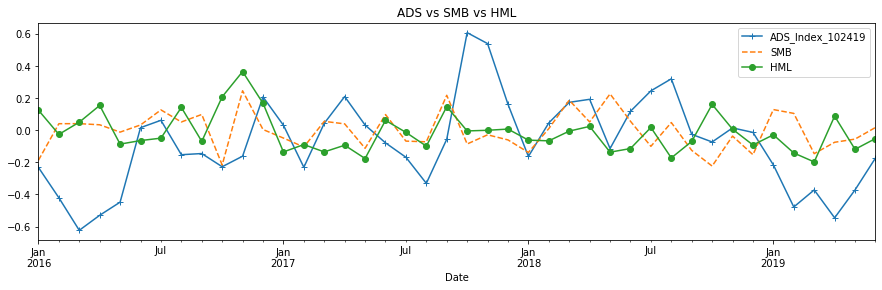

In [23]:
month_agg[['ADS_Index_102419','SMB','HML']].loc['2016-01-04':].plot(figsize=(15,4), style=['-+','--','-o'], 
                                                                    title = 'ADS vs SMB vs HML')


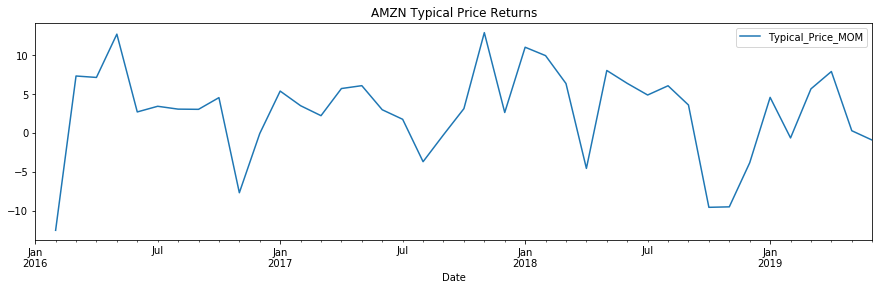

In [24]:
month_agg[['Typical_Price_MOM']].loc['2016-01-04':].plot(figsize=(15,4), style=['-','b'] , 
                                                        title = 'AMZN Typical Price Returns')

#### We can see AMZN trend is most similar to that of ADS index and SMB index, so we would use thes two as high frequency variables to predict AMZN Quaterly returns

### Resampling daily data to Quaterly aggregated data

In [25]:
quaterly_agg = amzn_AF.resample('Q').mean()

In [26]:
quaterly_agg
quaterly_agg['Typical_Price_QOQ'] = (np.log(quaterly_agg.Typical_Price) - np.log(quaterly_agg.Typical_Price.shift(1))) * 100.
quaterly_agg.tail()

,Open,Close,High,Low,Volume,Typical_Price,Mkt-RF,SMB,HML,RF,ADS_Index_102419,Typical_Price_QOQ
Date,,,,,,,,,,,,
2018-06-30,1588.499689,1587.434530,1601.851879,1571.919062,4.491819e+06,1587.068490,0.055313,0.113437,-0.076250,0.006328,0.063044,10.525153
2018-09-30,1880.047623,1880.693493,1896.665711,1861.189370,4.580038e+06,1879.516191,0.106349,-0.053492,-0.077937,0.007635,0.191399,16.912580
2018-12-31,1672.156027,1662.728893,1699.961902,1631.938727,7.576563e+06,1664.876507,-0.246825,-0.139365,0.033492,0.008603,-0.025667,-12.126345
2019-03-31,1660.534420,1664.341315,1679.465586,1644.461478,5.176570e+06,1662.756126,0.208525,0.027049,-0.121639,0.009656,-0.351144,-0.127441
2019-06-30,1863.109991,1863.000475,1876.760628,1846.824126,4.034922e+06,1862.195076,0.056825,-0.038571,-0.028413,0.009333,-0.366605,11.327940


### Model - 1  using Typical Price 


In [27]:
AllModel_rmse = []

In [28]:
y, yl, x, yf, ylf, xf = mix_freq(quaterly_agg.Typical_Price_QOQ,month_agg.Typical_Price_MOM, "3m", 1, 3,
                                 start_date=datetime.datetime(2016,1,31),
                                 end_date=datetime.datetime(2018,6,30))

In [29]:
res = estimate(y, yl, x, poly='beta')
res.x

/Users/haroonperveez/Machine Learning in Finance/Assignment 2/midas/adl.py:32: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c = np.linalg.lstsq(np.concatenate([np.ones((len(xw), 1)), xw.reshape((len(xw), 1)), yl], axis=1), y)[0]


array([14.97685529,  1.55258314,  1.08658955,  3.8561789 , -0.92195455])

In [30]:
fc = forecast(xf, ylf, res, poly='beta')
forecast_df = fc.join(yf)
forecast_df['gap'] = forecast_df.Typical_Price_QOQ - forecast_df.yfh 
forecast_df

,yfh,Typical_Price_QOQ,gap
Date,,,
2018-09-30,17.141830,16.912580,-0.229250
2018-12-31,7.871891,-12.126345,-19.998236
2019-03-31,13.623424,-0.127441,-13.750865
2019-06-30,16.604120,11.327940,-5.276180


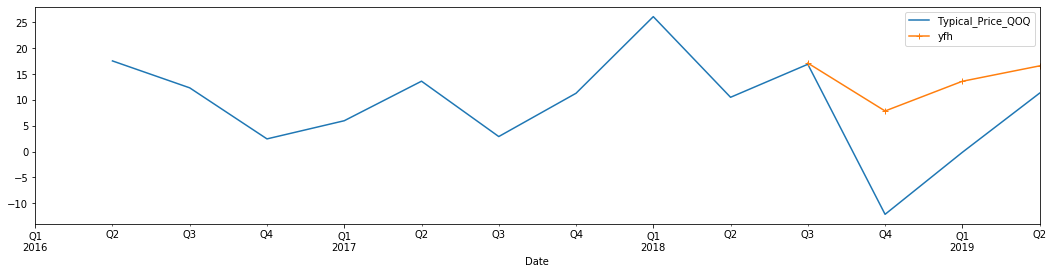

In [31]:
quaterly_agg.join(fc)[['Typical_Price_QOQ','yfh']].loc['2016-1-31':].plot(style=['-','-+'], figsize=(18, 4))

In [32]:
rmse = ((forecast_df.Typical_Price_QOQ - forecast_df.yfh) ** 2).mean() ** .5
rmse

12.418799924137089

In [33]:
AllModel_rmse.append(rmse)
AllModel_rmse

[12.418799924137089]

### Model 2 - considering typical price and change in volume MOM


In [34]:
y, yl, x1, x2, yf, ylf, x1f, x2f =mix_freq2(quaterly_agg.Typical_Price_QOQ,month_agg.Volume_MOM,month_agg.Typical_Price_MOM, "3m","3m", 1, 3,
                                 start_date = datetime.datetime(2016,1,31),
                                 end_date = datetime.datetime(2018,6,30))

In [35]:
res = estimate2(y, yl, x1, x2, poly1='expalmon', poly2='expalmon')
res.x

/Users/haroonperveez/Machine Learning in Finance/Assignment 2/midas/adl.py:85: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c = np.linalg.lstsq(np.concatenate([np.ones((len(xw1), 1)), xw1.reshape((len(xw1), 1)), xw2.reshape((len(xw2), 1)), yl], axis=1), y)[0]


array([  5.74240454,  -0.44764158,   1.6983523 ,  31.25785094,
       -10.61899611,  29.85676769, -10.11174687,  -0.29455448])

In [36]:
fc = forecast2(x1f, x2f, ylf, res, poly1='expalmon',poly2='expalmon')
forecast_df = fc.join(yf)
forecast_df['gap'] = forecast_df.Typical_Price_QOQ - forecast_df.yfh  
forecast_df

,yfh,Typical_Price_QOQ,gap
Date,,,
2018-09-30,18.178012,16.912580,-1.265432
2018-12-31,5.234748,-12.126345,-17.361092
2019-03-31,-3.918332,-0.127441,3.790891
2019-06-30,14.296877,11.327940,-2.968938


In [37]:
rmse = ((forecast_df.Typical_Price_QOQ - forecast_df.yfh) ** 2).mean() ** .5
rmse

9.030424920502949

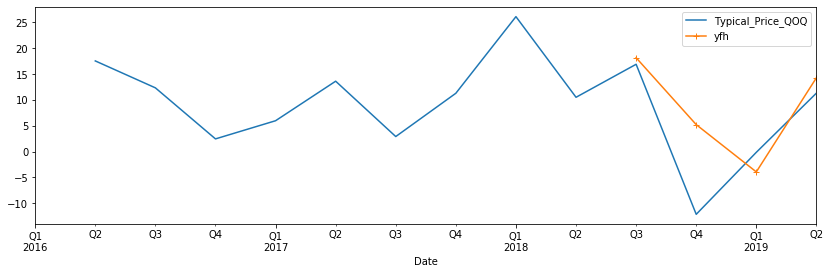

In [38]:
quaterly_agg.join(fc)[['Typical_Price_QOQ','yfh']].loc['2016-1-31':].plot(style=['-','-+'], figsize=(14, 4))

In [39]:
AllModel_rmse.append(rmse)
AllModel_rmse

[12.418799924137089, 9.030424920502949]

### Model - 3 - considering Typical Price and ADS index


In [40]:
y, yl, x1, x2, yf, ylf, x1f, x2f =mix_freq2(quaterly_agg.Typical_Price_QOQ,month_agg.Typical_Price_MOM,month_agg.ADS_Index_102419, "3m","3m", 1, 3,
                                 start_date = datetime.datetime(2016,1,31),
                                 end_date = datetime.datetime(2018,6,30))

In [41]:
res = estimate2(y, yl, x1, x2, poly1='expalmon', poly2='expalmon')
res.x

array([ 14.37987168,   1.14764491,  30.12884617,  54.74782615,
       -14.1355132 ,  11.30600261,  -4.7820713 ,  -0.87202512])

In [42]:
fc = forecast2(x1f, x2f, ylf, res, poly1='expalmon',poly2='expalmon')
forecast_df = fc.join(yf)
forecast_df['gap'] = forecast_df.Typical_Price_QOQ - forecast_df.yfh  
forecast_df

,yfh,Typical_Price_QOQ,gap
Date,,,
2018-09-30,17.704719,16.912580,-0.792139
2018-12-31,6.342938,-12.126345,-18.469282
2019-03-31,13.676778,-0.127441,-13.804219
2019-06-30,2.422415,11.327940,8.905524


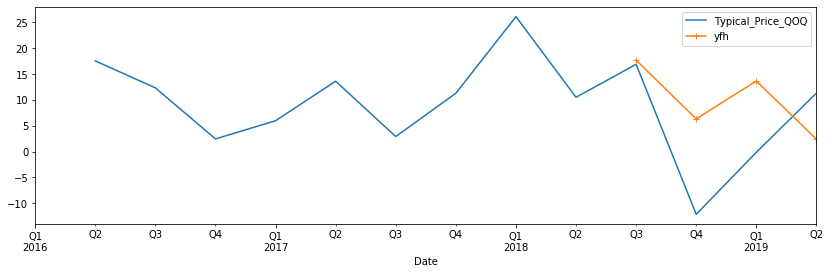

In [43]:
quaterly_agg.join(fc)[['Typical_Price_QOQ','yfh']].loc['2016-1-31':].plot(style=['-','-+'], figsize=(14, 4))

In [44]:
rmse = ((forecast_df.Typical_Price_QOQ - forecast_df.yfh) ** 2).mean() ** .5
rmse

12.365341678364334

In [45]:
AllModel_rmse.append(rmse)
AllModel_rmse

[12.418799924137089, 9.030424920502949, 12.365341678364334]

### Model 4 - using Typical Price and SMB 


In [46]:
y, yl, x1, x2, yf, ylf, x1f, x2f =mix_freq2(quaterly_agg.Typical_Price_QOQ,month_agg.Typical_Price_MOM,month_agg.SMB, "3m","3m", 1, 3,
                                 start_date = datetime.datetime(2016,1,31),
                                 end_date = datetime.datetime(2018,6,30))

In [47]:
res = estimate2(y, yl, x1, x2, poly1='expalmon', poly2='expalmon')
res.x

array([ 12.75734979,   1.67324987, -42.10639538,  83.28213468,
       -27.14804925, -12.59763034,  56.18519856,  -0.97014458])

In [48]:
fc = forecast2(x1f, x2f, ylf, res, poly1='expalmon',poly2='expalmon')
forecast_df = fc.join(yf)
forecast_df['gap'] = forecast_df.Typical_Price_QOQ - forecast_df.yfh  
forecast_df

,yfh,Typical_Price_QOQ,gap
Date,,,
2018-09-30,13.473777,16.912580,3.438803
2018-12-31,10.188815,-12.126345,-22.315159
2019-03-31,19.302598,-0.127441,-19.430039
2019-06-30,7.847068,11.327940,3.480872


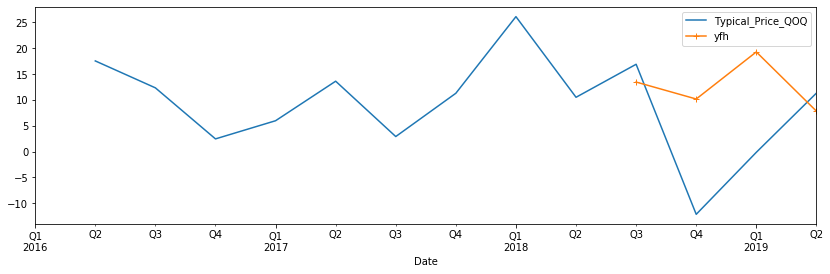

In [49]:
quaterly_agg.join(fc)[['Typical_Price_QOQ','yfh']].loc['2016-1-31':].plot(style=['-','-+'], figsize=(14, 4))

In [50]:
rmse = ((forecast_df.Typical_Price_QOQ - forecast_df.yfh) ** 2).mean() ** .5
rmse

14.995287417183233

In [51]:
AllModel_rmse.append(rmse)
AllModel_rmse

[12.418799924137089, 9.030424920502949, 12.365341678364334, 14.995287417183233]

### RMSE Graph

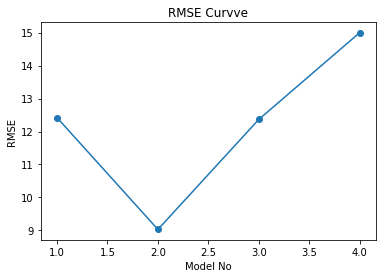

In [52]:
plt.scatter([1,2,3,4],list(AllModel_rmse) )
plt.plot([1,2,3,4],list(AllModel_rmse))
plt.xlabel('Model No')
plt.ylabel('RMSE')
plt.title('RMSE Curvve')
plt.show()


### Checking for Optimum horizons in model 2

In [53]:
y, yl, x1, x2, yf, ylf, x1f, x2f =mix_freq2(quaterly_agg.Typical_Price_QOQ,month_agg.Volume_MOM,month_agg.Typical_Price_MOM, "3m","3m", 1, 4,
                                 start_date = datetime.datetime(2016,1,31),
                                 end_date = datetime.datetime(2018,6,30))

In [54]:
res = estimate2(y, yl, x1, x2, poly1='expalmon', poly2='expalmon')
res.x

array([ 15.71586945,   0.23088182,   1.71536194, -10.42493607,
         2.69897618,  -3.96906067,  -6.19974111,  -0.96915381])

In [55]:
fc = forecast2(x1f, x2f, ylf, res, poly1='expalmon',poly2='expalmon')
forecast_df = fc.join(yf)
forecast_df['gap'] = forecast_df.Typical_Price_QOQ - forecast_df.yfh  
forecast_df

,yfh,Typical_Price_QOQ,gap
Date,,,
2018-09-30,12.356687,16.912580,4.555893
2018-12-31,12.611929,-12.126345,-24.738274
2019-03-31,12.719434,-0.127441,-12.846875
2019-06-30,14.789736,11.327940,-3.461797


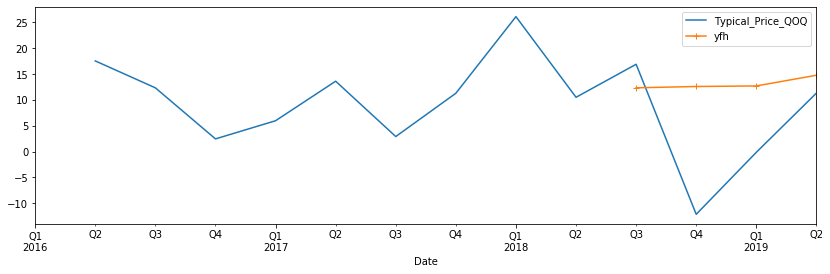

In [56]:
quaterly_agg.join(fc)[['Typical_Price_QOQ','yfh']].loc['2016-1-31':].plot(style=['-','-+'], figsize=(14, 4))

In [57]:
rmse = ((forecast_df.Typical_Price_QOQ - forecast_df.yfh) ** 2).mean() ** .5
rmse

14.228181456005398

### We can observe by increasing horizon, we do generalize the model around mean and it does not follow the predictive trend,we can chose 3 as optimal horizon

### Retaining it for 3 Horizon - Model 2

In [58]:
y, yl, x1, x2, yf, ylf, x1f, x2f =mix_freq2(quaterly_agg.Typical_Price_QOQ,month_agg.Volume_MOM,month_agg.Typical_Price_MOM, "3m","3m", 1, 3,
                                 start_date = datetime.datetime(2016,1,31),
                                 end_date = datetime.datetime(2018,3,31))

In [59]:
res = estimate2(y, yl, x1, x2, poly1='expalmon', poly2='expalmon')
res.x

array([ 17.6301778 ,  -0.20227221,   1.51940622,  22.59972048,
        -7.70066138,  65.0703131 , -16.44713711,  -1.51776483])

In [60]:
fc = forecast2(x1f, x2f, ylf, res, poly1='expalmon',poly2='expalmon')
forecast_df = fc.join(yf)
forecast_df['gap'] = forecast_df.Typical_Price_QOQ - forecast_df.yfh  
forecast_df

,yfh,Typical_Price_QOQ,gap
Date,,,
2018-06-30,-8.403542,10.525153,18.928695
2018-09-30,15.921161,16.912580,0.991420
2018-12-31,-0.137239,-12.126345,-11.989106
2019-03-31,20.386244,-0.127441,-20.513685
2019-06-30,18.440631,11.327940,-7.112691


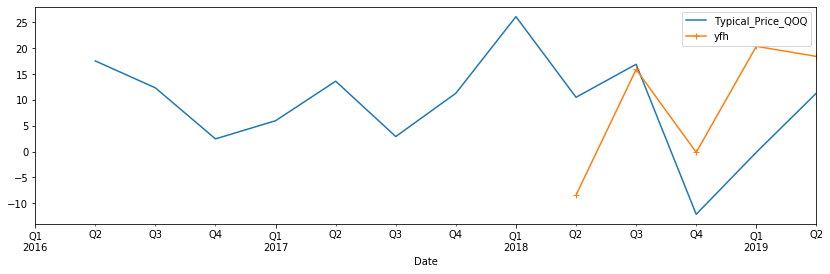

In [61]:
quaterly_agg.join(fc)[['Typical_Price_QOQ','yfh']].loc['2016-1-31':].plot(style=['-','-+'], figsize=(14, 4))

In [62]:
rmse = ((forecast_df.Typical_Price_QOQ - forecast_df.yfh) ** 2).mean() ** .5
rmse

13.960076483012912

In [63]:
forecast_df

,yfh,Typical_Price_QOQ,gap
Date,,,
2018-06-30,-8.403542,10.525153,18.928695
2018-09-30,15.921161,16.912580,0.991420
2018-12-31,-0.137239,-12.126345,-11.989106
2019-03-31,20.386244,-0.127441,-20.513685
2019-06-30,18.440631,11.327940,-7.112691


In [64]:
y_pred = [] * 10

for i in range(len(forecast_df)+1):
    if i == 0:
        y_pred.append(1587.068490)
    else:
        y_pred.append(math.exp(forecast_df['yfh'][i-1]/100) * y_pred[i-1])

In [65]:
y_pred[0:-1]

[1587.06849,
 1459.1486974741615,
 1710.977401238427,
 1708.6308829673453,
 2095.002682249509]

In [66]:
quaterly_agg.Typical_Price['2018-09-30':]

Date
2018-09-30    1879.516191
2018-12-31    1664.876507
2019-03-31    1662.756126
2019-06-30    1862.195076
Freq: Q-DEC, Name: Typical_Price, dtype: float64

In [67]:
Trading_df = pd.DataFrame({'Actual_Typical_Price':quaterly_agg.Typical_Price['2018-06-30':],
                           'Predicted_Typical_Price' : y_pred[0:-1]
                          })

# Monthly Trading Strategy for MIDAS

In [68]:
amount = 10000
signal = 0
Amount = []
balance = 0
action = []
portfolio = 0
Portfolio = []
stocks = 0
Stocks = []

for i in range(len(Trading_df)-1):
    if Trading_df['Predicted_Typical_Price'][i+1] > Trading_df['Actual_Typical_Price'][i]:
        if signal == 0:
            action.append('Buy')
            stocks = int(amount / Trading_df['Actual_Typical_Price'][i])
            balance = int(amount % Trading_df['Actual_Typical_Price'][i])
            portfolio = stocks * Trading_df['Actual_Typical_Price'][i]
            signal = 1
            amount = portfolio + balance
            print('Stock:',Trading_df['Actual_Typical_Price'][i] ,'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
        else:
            action.append('Bought--Holding')
            portfolio = stocks * Trading_df['Actual_Typical_Price'][i]
            amount = portfolio + balance
            print('Stock:',Trading_df['Actual_Typical_Price'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
            
    elif Trading_df['Predicted_Typical_Price'][i+1] < Trading_df['Actual_Typical_Price'][i]:
        if signal == 1:
            action.append('Sell')
            portfolio = stocks * Trading_df['Actual_Typical_Price'][i]
            
            signal = 0
            stocks = 0
            amount = balance + portfolio
            portfolio = 0
            balance = 0
            print('Stock:',Trading_df['Actual_Typical_Price'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
        else:
            action.append('Price-Prediction-Already-Lower')
            print('Stock:',Trading_df['Actual_Typical_Price'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
 



Stock: 1587.068490359375 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000
Stock: 1879.5161914444452 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000
Stock: 1664.876507460317 Action: Buy Portfolio: 9989.26 Stocks: 6 Balance_init: 10 total($) 9999.26
Stock: 1662.756126234972 Action: Bought--Holding Portfolio: 9976.54 Stocks: 6 Balance_init: 10 total($) 9986.54


In [69]:
Amount

[10000, 10000, 9999.0, 9987.0]

In [71]:
list(Amount).mean()

AttributeError: 'list' object has no attribute 'mean'

In [ ]:
import statistics
>>> statistics.stdev(A_rank)

In [72]:
Returns = [9999.26+9986.54+111813]

In [73]:
average(Returns)

NameError: name 'average' is not defined

In [74]:
import statistics
statistics.stdev(Returns)

StatisticsError: variance requires at least two data points